# Rozpoznawanie mowy - projekt
Przed uruchomieniem projektu sprawdź, czy masz zainstalowane wszystkie potrzebne biblioteki.

In [1]:
from scipy.io import wavfile
from matplotlib import pyplot as plt
import numpy as np
import sys
import wave
import scipy.signal
import os
import librosa
import librosa.util
from dtw import dtw
from numpy.linalg import norm
import librosa.display
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

### 1. Funkcja do wczytywania plików z sygnałami (load_voice_signal()). Funkcja normalizuje sygnał poprzez podzielenie sygnału przez moduł sygnału.

In [2]:
def load_voice_signal(filename):
    samplerate, data = wavfile.read('commends/' + filename + '.wav')
    words = data / np.amax(np.absolute(data))
    words = words[::,0]
    timestamps = np.array([i[0] / samplerate for i in np.ndindex(words.shape)])
    return words, timestamps

#### Przykład wizualizacji fali dźwiękowej

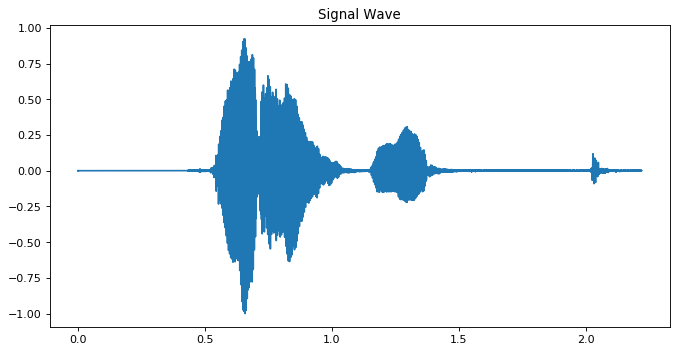

In [3]:
words, timestamps = load_voice_signal('G11')

#y = words[32000:70000]
#x = timestamps[32000:70000]
y = words
x = timestamps
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Signal Wave')

plt.plot(x,y)

plt.show()

### 2. Funkcja, która wyciąga cechy sygnału (extract_features()).

In [4]:
def extract_features(word):
    my_mfcc = np.mean(librosa.feature.mfcc(y = word, sr = 44100, n_mfcc = 40).T, axis = 0)
    my_mfcc = np.array([my_mfcc])
    return my_mfcc

# Ekstrakcja cech i podział na zbiór uczący i testowy w stosunku 4:1.
### Podział na zbiór uczący i testowy przeprowadzony w sposób losowy

In [7]:
from sklearn.model_selection import train_test_split

commands = ['otwórz', 'zamknij', 'gorąco', 'zimno', 'ciemno', 'jasno', 'stop', 'rozwiń', 'zasłoń']

file_ids, commands = zip(*[(person + str(cmd_idx * 5 + n_record + 1), cmd)
                      for cmd_idx, cmd in enumerate(commands)
                      for person in 'OJG'
                      for n_record in range(5)])

words = [load_voice_signal(file_id)[0] for file_id in file_ids]

features = np.squeeze([extract_features(word) for word in words])

(features_train, features_test,
words_train, words_test,
commands_train, commands_test) = train_test_split(features, words, commands, test_size=0.2)

### Support Vector Classification - Wspierający wektor klasyfikacji:

https://www.icsr.agh.edu.pl/~dzwinel/files/courses/C3-Classifiers.pdf



In [8]:
my_svc = SVC(kernel = "linear", C = 0.025)
my_svc.fit(features_train, commands_train)
predictions = my_svc.predict(features_test)
print('Dokładność klasyfikatora:{}'.format(accuracy_score(commands_test, predictions)))

Dokładność klasyfikatora:0.6296296296296297


### 5. Porównanie sygnałów używając DWT
http://cs.uccs.edu/~cs525/studentproj/projS2010/plama/doc/cs525-SpeechRecogntion.pdf

http://research.cs.tamu.edu/prism/lectures/sp/l9.pdf

http://web.science.mq.edu.au/~cassidy/comp449/html/ch11s02.html

https://github.com/crawles/dtw/blob/master/Speech_Recognition_DTW.ipynb

http://iosrjournals.org/iosr-jece/papers/NCIEST/Volume%202/3.%2012-16.pdf



### a) Obliczenie znormalizowanej odległości między komendami: zamknij oraz stop korzystając z metody DWT

Odległość znormalizowana między komendą zamknij oraz stop wynosi: 76.42728238052685


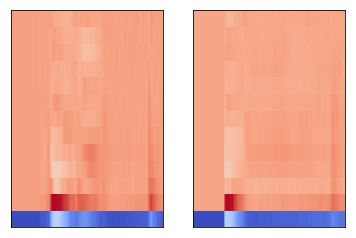

In [18]:
fs = 44100 # częstotliwość próbkowania sygnału
same_words1 = [word for word, cmd in zip(words_test, commands_test) if cmd == 'zamknij']
same_words2 = [word for word, cmd in zip(words_test, commands_test) if cmd == 'stop']
word_1 = librosa.feature.mfcc(same_words1[0], fs, n_mfcc = 13)
plt.subplot(1, 2, 1)
librosa.display.specshow(word_1)
word_2 = librosa.feature.mfcc(same_words2[0], fs, n_mfcc = 13)
plt.subplot(1, 2, 2)

librosa.display.specshow(word_2)

dist, cost, acc_cost, path = dtw(word_2.T, word_1.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
print('Odległość znormalizowana między komendą zamknij oraz stop wynosi:' , dist)


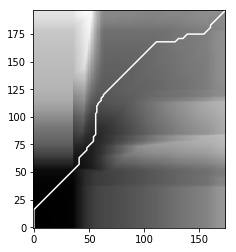

In [19]:
plt.imshow(acc_cost.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.show()

### b) Obliczenie znormalizowanej odległości między komendą otwórz u dwóch różnych osób:

Odległość znormalizowana między komendami otwórz wypowiedziana przez dwie różne osoby wynosi: 4.756999420506903


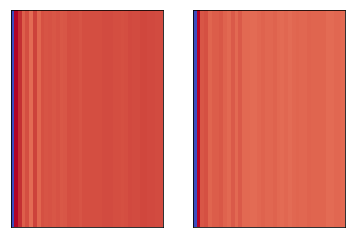

In [21]:
path1 = 'J' + str(1)        
path2 = 'O' + str(1)
word_1 = extract_features(load_voice_signal(path1)[0])
word_2 = extract_features(load_voice_signal(path2)[0])
plt.subplot(1, 2, 1)
librosa.display.specshow(word_1)
plt.subplot(1, 2, 2)
librosa.display.specshow(word_2)

dist, cost, acc_cost, path = dtw(word_2.T, word_1.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
print('Odległość znormalizowana między komendami otwórz wypowiedziana przez dwie różne osoby wynosi:' , dist)

Obliczenie znormalizowanej odległości między komendą zamknij u jednej osoby:

Odległość znormalizowana między komendami otwórz wypowiedziana przez tą samą osobę: 1.9417552141448073


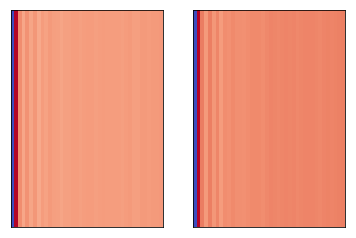

In [22]:
path1 = 'J' + str(6)        
path2 = 'J' + str(10)
word_1 = extract_features(load_voice_signal(path1)[0])
word_2 = extract_features(load_voice_signal(path2)[0])
plt.subplot(1, 2, 1)
librosa.display.specshow(word_1)
plt.subplot(1, 2, 2)
librosa.display.specshow(word_2)

dist, cost, acc_cost, path = dtw(word_2.T, word_1.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
print('Odległość znormalizowana między komendami otwórz wypowiedziana przez tą samą osobę:' , dist)


### Macierz odległości

Macierz stworzona z wykorzystaniem algorytmu DWT - jest to graficzne przedstawienie odległości między dwiema analizowanymi komendami

In [23]:
def compute_and_plot_distances(my_com, paths=None, features=None):
    if features is None:
        if paths is None:
            raise ValueError('Both paths and features are empty')
        features = np.array([extract_features(load_voice_signal(path)[0]).T for path in paths])

    N = len(features)
    my_dist = np.ndarray(shape=(N, N))
    for i in range(N):
        for j in range(i, N):
            dist, _, _, _ = dtw(features[i], features[j], dist=lambda x, y: np.linalg.norm(x - y, ord=1)) 
            my_dist[i, j] = dist
            my_dist[j, i] = dist

    plt.figure(figsize=(5,5), dpi= 80, facecolor='w', edgecolor='k')
    plt.imshow(my_dist, cmap='viridis')
    plt.colorbar()
    plt.tick_params(axis = 'on', bottom='off', top='on', labelbottom='off', labeltop='on')
    plt.xticks(range(len(my_dist)), my_com, rotation=90)
    plt.yticks(range(len(my_dist)), my_com)
    plt.show()

Macierz odległości - porównanie odległości między komendą GORĄCO wypowiedzianą przez jedną osobę


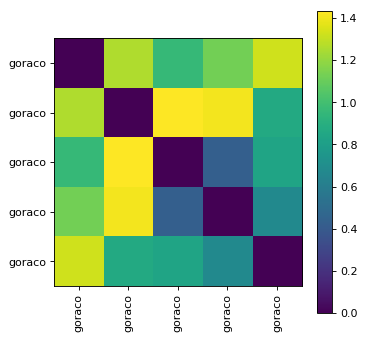

In [27]:
my_com = ['goraco'] * 5 

paths = ['G{}'.format(i) for i in range(11, 16)]

print('Macierz odległości - porównanie odległości między komendą GORĄCO wypowiedzianą przez jedną osobę')
compute_and_plot_distances(my_com, paths)

### Macierz porównania słowa otworz dla trzech różnych osób

Macierz odległości - porównanie odległości między komendą OTWORZ wypowiedziane przez trzy różne osoby


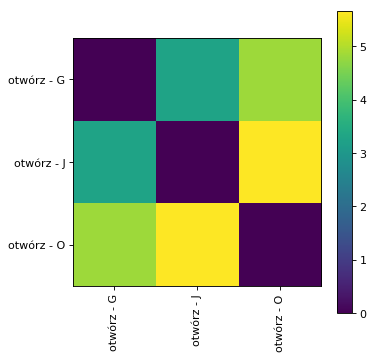

In [28]:
my_com = ['otwórz - G', 'otwórz - J', 'otwórz - O']

paths = ['{}2'.format(p) for p in 'GJO']

print('Macierz odległości - porównanie odległości między komendą OTWORZ wypowiedziane przez trzy różne osoby')

compute_and_plot_distances(my_com, paths)

Macierz odległości - porównanie odległości między wszystkimi komendami dla całego zbioru danych


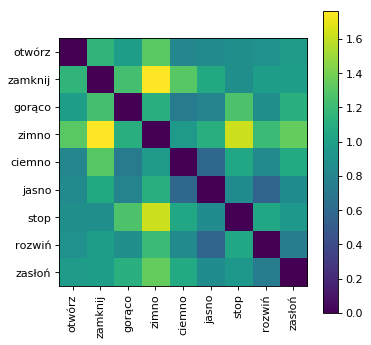

In [29]:
commands = ['otwórz', 'zamknij', 'gorąco', 'zimno', 'ciemno', 'jasno', 'stop', 'rozwiń', 'zasłoń']

paths_groups = [['{}{}'.format(p, 5 * cmd_idx + offset + 1) for p in 'GJO' for offset in range(5)]
                for cmd_idx in range(len(commands))]

features_groups = [np.array([extract_features(load_voice_signal(path)[0]).T for path in group])
                   for group in paths_groups]

features = [group.mean(axis=0) for group in features_groups]

print('Macierz odległości - porównanie odległości między wszystkimi komendami dla całego zbioru danych')
compute_and_plot_distances(commands, features=features)

# Wnioski

1. Sygnał mowy jest sygnałem ciężkim do analizy. Zależy on od barwy głosu, od stanu emocjonalnego danej osoby (czy wypowiada się będąc spokojnym czy zdenerwowanym) czy też stopnia zmęczenia. Z tego względu zbiór nagrań zawierający te samo sowo może mieć wysokie odchylenie standardowe odległości, co może spowodować błędną klasyfikację. Szczególnie, jeżeli analizowane sygnały pochodzą od wielu osób. 
 
2. Problemem podczas wykonywania projektu, była niewielka zebrana próba - posiadano zaledwie 15 nagrań tego samego słowa. Były to słowa nagrywane przez trzy osoby pięciokrotnie w różnych porach dnia i o różnym stopniu zmęczenia i nastroju osoby nagrywającej słowa. W związku z tym należałoby znormalizować sposób akwizycji sygnałów oraz stworzyć większą bazę danych. 

